## Jeux de cartes

Le site de la commission européenne met à disposition un certain nombre de données géographiques. On y trouve notamment une [page](http://ec.europa.eu/eurostat/fr/web/gisco/geodata/reference-data/administrative-units-statistical-units) permettant de télécharger les contours d'entités administratives, notamment les pays du monde.

La version actuelle en téléchargement est celle de 2014. On peut alors télécharger le fichier shapefile au 1/3000000. Le format shapefile est un format géographique standard qui permet de décrire la géométrie d'objets d'écrits, à base de points, de lignes et de polygones.

On peut alors récupérer sur la page indiquée le fichier `CNTR_2014_03M_SH.zip` dans lequel, on trouvera un fichier à l'extension `.shp` contenant les contours recherchés.

In [1]:
shapefile_path = "./CNTR_2014_03M_SH/Data/CNTR_RG_03M_2014.shp"
shapefile_path = "/Users/xo/Documents/github/CNTR_2014_03M_SH/Data/CNTR_RG_03M_2014.shp"

Les bibliothèques `shapely`, `descartes` et `fiona` permettent de lire ces fichiers et de tracer les polygones contenus dans ces fichiers.

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

On peut alors choisir d'afficher la France métropolitaine et ses pays frontaliers. On retrouve les informations relatives aux polygones décrits dans le fichier shapefile dans le dictionnaire `'properties'`. On a notamment accès aux codes des pays représentés `['CNTR_ID']`.

Ici on choisit d'afficher les polygones d'une couleur différente en fonction du pays.

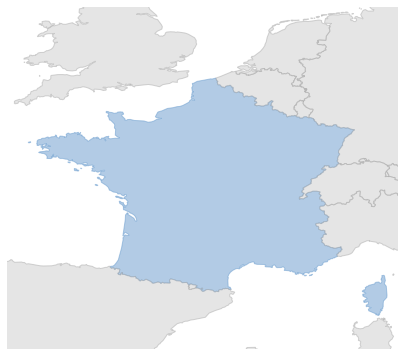

In [3]:
# Geometry packages
from shapely.geometry import MultiPolygon, Polygon, shape
from descartes import PolygonPatch

# Read shapefiles
import fiona

def extract_polygons(p):
    m = [MultiPolygon(s) for s in p if s.geom_type == "MultiPolygon"]
    m += [MultiPolygon([s]) for s in p if s.geom_type == "Polygon"]
    return m

# Isolate France contours
france = [shape(pol['geometry'])
          for pol in fiona.open(shapefile_path)
          if pol['properties']['CNTR_ID'] == 'FR']

france_mp = extract_polygons(france)

# Include neighbouring countries contours
neighbours  = [shape(pol['geometry'])
          for pol in fiona.open(shapefile_path)
          if pol['properties']['CNTR_ID'] in
          ['DE', 'IT', 'ES', # Germany, Italy, Spain
           'PT', 'UK', 'BE', # Portugal, United Kingdom, Belgium
           'CH', 'LU', 'AD', # Switzerland, Luxembourg, Andorra
           'NL', 'AT', 'LI',  # Netherlands, Austria, Liechtenstein
          ]]

neighbours_mp = extract_polygons(neighbours)

# Plot the map
fig = plt.figure()
ax = fig.gca()

for mp in france_mp:
    for idx, p in enumerate(mp):
        ax.add_patch(PolygonPatch(p, fc='#6699cc', ec='#6699cc',
                                  alpha=0.5, zorder=2))
for mp in neighbours_mp:
    for idx, p in enumerate(mp):
        ax.add_patch(PolygonPatch(p, fc='#cccccc', ec='#aaaaaa',
                                  alpha=0.5, zorder=2))

# Finitions

ax.axis('scaled')
ax.set_xlim((-6, 10))
ax.set_ylim((40, 54))
ax.set_xticks([])
ax.set_yticks([])
fig.set_size_inches(7, 7)
ax.set_frame_on(False)

## Coordonnées

La carte présentée ci-dessus est déformée/dilatée par rapport à l'image qui nous est familière.

Les données que nous avons récupérées sont fournies en latitude/longitude dans le référentiel ETRS89. La Terre est modélisée au premier ordre par une sphère, mais les modélisations plus précises font appel à un ellipsoïde de référence. Historiquement, chaque pays maintient son système de référence; en effet, la dérive des continents complique l'utilisation d'un système de référence mondial.

Pour les systèmes GPS notamment, un référentiel normalisé mondial a été proposé: le WGS84 (*World Geodetic System 1984*, après 1972, 1964, 1960).  
Celui-ci définit pour l'ellipsoïde de référence:
 - un demi-grand axe $a	= 6\,378\,137\,m$
 - un aplatissement $f = 1\,/\,298,257\,223\,563$
 
Pour les précisions qui nous intéressent dans notre exemple, les systèmes ETRS89 et WGS84 sont compatibles. On va même, pour la suite, pousser jusqu'à considérer que les coordonnées manipulées sont compatibles avec des coordonnées sphériques.

## Projections

Pour afficher une carte à l'écran, on choisit systématiquement une projection, c'est-à-dire une manière de représenter l'information de la surface d'une sphère sur une surface plane.

La projection la plus connue est celle de Mercator[^1], qui date du XVIe siècle, utilisée par les marins. C'est une projection *conforme*, qui respecte les angles et les formes. Les méridiens et les parallèles sont des droites perpendiculaires, et la déformation Est-Ouest inhérente à la projection sur un cône est compensée par une déformation Nord-Sud de même ampleur : l'échelle Est-Ouest est toujours de l'ordre de l'échelle Nord-Sud.

![Mercator](./566px-Mercator_projection_SW.jpg "Projection de Mercator")

D'autres projections sont *équivalentes*, c'est-à-dire qu'elles conservent localement les surfaces, mais beaucoup des projections les plus utilisées sont finalement ni conformes, ni équivalentes, mais des compromis.

À cet égard, la National Geographic Society a longtemps utilisé la projection Winkel-Tripel[^1], conçue pour minimiser les distorsions de surface, de direction et de distance (d'où le terme allemand de *tripel*). Cette projection est très esthétique et harmonieuse, mais cette harmonie vient à un prix : il n'existe pas de formule exacte pour repasser des coordonnées cartésiennes en $(x,y)$ à des coordonnées en latitude et longitude.

![Winkel-Tripel](./640px-Winkel_triple_projection_SW.jpg "Projection de Winkel-Tripel")

Beaucoup de projections ne permettent pas d'afficher le globe terrestre dans son intégralité, au moins à cause des discontinuités aux pôles. On trouve notamment des projections qui sont élégantes localement mais beaucoup moins à l'échelle mondiale. La projection de Lambert[^1] est une projection conique *conforme* qui sert aussi de référence en France.

![LCC](./640px-Lambert_conformal_conic_projection_SW.jpg "Projection conforme conique de Lambert")

Les pilotes aiment cette projection parce qu'à l'échelle où l'on trace ces cartes, une ligne droite entre deux points est proche du grand cercle qui passe par ces deux points. Dans ce système de projection conforme, les méridiens sont des droites concourantes, et les parallèles des arcs de cercle centrés sur le point de convergence des méridiens.

[^1]: Images issues de [Wikipedia](https://en.wikipedia.org/wiki/List_of_map_projections)

## La projection Lambert 93

La projection Lambert 93 est la projection officielle utilisée pour les cartes de France métropolitaine. Elle utilise deux parallèles sécants $\varphi_1$ à 44°N, $\varphi_2$ à 49°N, le méridien de référence $\lambda_0$ à 3°E (Méridien de Greenwich) et le parallèle d'origine $\varphi_0$ à 46°30'.

On peut calculer la projection $(x,y)$ des coordonnées en latitude $\varphi$ et longitude $\lambda$ avec les formules suivantes.


$$
    x = \rho \sin(n (\lambda - \lambda_0))\\
    y = \rho_0 - \rho \cos(n (\lambda - \lambda_0))
$$

On choisit ici de rester en modèle sphérique pour ne pas trop compliquer l'expression de $n$.

$$
    n = \frac{\ln(\cos \varphi_1 \sec \varphi_2)}{\ln (\tan (\frac14 \pi + \frac12 \varphi_2) \cot (\frac14 \pi + \frac12\varphi_1))}
$$

Les expressions manquantes sont alors exprimées comme suit.

$$
    \rho = F \cot^{n} (\tfrac14 \pi + \tfrac12 \varphi)\\
    \rho_0 = F \cot^{n} (\tfrac14 \pi + \tfrac12 \varphi_0)\\
    F = \frac{\cos \varphi_1 \tan^{n} (\frac14 \pi + \frac12 \varphi_1)}{n} 
$$  

La fonction suivante qu'il est inutile de détailler plus en profondeur va alors nous être utile.


In [4]:
# Parameters for Lambert 93 projection
[lon0, lat0, lat1, lat2] = [np.radians(x) for x in [3, 46.5, 44, 49]]

# Lambert conformal conic projection (from spherical coordinates)
def sph2lcc(lon, lat):
    n = np.sin(lat1)
    if (lat1 != lat2):
        n  = np.log(np.cos(lat1) / np.cos(lat2))
        n /= np.log(np.tan(np.pi/4 + lat2/2) / np.tan(np.pi/4 + lat1/2))
    F = np.cos(lat1) * np.exp(n * np.log(np.tan(np.pi/4 + lat1/2)))/n
    rho = F / np.exp(n * np.log(np.tan(np.pi/4 + lat/2)))
    rho0 = F / np.exp(n * np.log(np.tan(np.pi/4 + lat0/2)))
    x = rho * np.sin(n * (lon-lon0))
    y = rho0 - rho * np.cos(n * (lon-lon0))
    return (x, y)

On peut alors désormais afficher notre carte dans une projection convenable.

In [5]:
def nice_plot(f_xy):
    fig = plt.figure()
    ax = fig.gca()

    for mp in france_mp:
        for (idx, p) in enumerate(mp):
            # Coordinate extraction
            lon = np.array([lon for (lon, _) in list(p.exterior.coords)])
            lat = np.array([lat for (_, lat) in list(p.exterior.coords)])
            # Coordinate projection
            x, y = sph2lcc(np.radians(lon), np.radians(lat))
            # Tracing the projected polygon
            new_pol = f_xy(x, y)
            ax.add_patch(PolygonPatch(new_pol, fc='#6699cc', ec='#6699cc',
                                      alpha=0.5, zorder=2))

    for mp in neighbours_mp:
        for (idx, p) in enumerate(mp):
            # Coordinate extraction
            lon = np.array([lon for (lon, _) in list(p.exterior.coords)])
            lat = np.array([lat for (_, lat) in list(p.exterior.coords)])
            # Coordinate projection
            x, y = sph2lcc(np.radians(lon), np.radians(lat))
            # Tracing the projected polygon
            new_pol = f_xy(x, y)
            ax.add_patch(PolygonPatch(new_pol, fc='#cccccc', ec='#aaaaaa',
                                      alpha=0.5, zorder=2))

    # Trimming borders

    x_min, _ = sph2lcc(np.radians(-4), np.radians(41))
    x_max, _ = sph2lcc(np.radians(10), np.radians(41))
    _, y_min = sph2lcc(np.radians(3), np.radians(41))
    _, y_max = sph2lcc(np.radians(3), np.radians(52))

    # Graticule

    for lon in np.radians(np.arange(-10, 15, 5)):
        lat_grat = np.radians(np.arange(30, 60))
        lon_grat = np.repeat(lon, len(lat_grat))
        x, y = sph2lcc(lon_grat, lat_grat)
        ax.add_line(plt.Line2D(x, y, color='#cccccc', alpha=0.5))

    for lat in np.radians(np.arange(30, 60, 5)):
        lon_grat = np.radians(np.arange(-10, 15))
        lat_grat = np.repeat(lat, len(lon_grat))
        x, y = sph2lcc(lon_grat, lat_grat)
        ax.add_line(plt.Line2D(x, y, color='#cccccc', alpha=0.5))

    # Finitions

    ax.set_xlim((x_min, x_max))
    ax.set_ylim((y_min, y_max))
    ax.set_xticks([])
    ax.set_yticks([])
    fig.set_size_inches(7, 7)
    ax.set_frame_on(False)

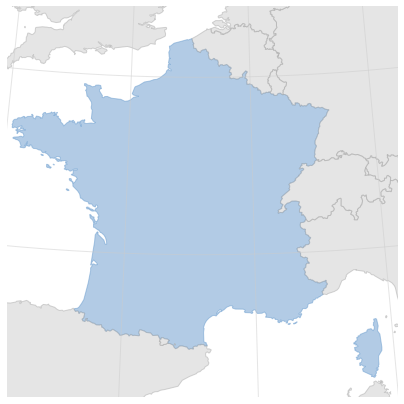

In [6]:
nice_plot(lambda x, y: Polygon([a for a in zip(x, y)]))

## L'algorithme de Visvalingam et Whyatt

Tout l'art de la cartographie consiste à trouver la bonne résolution de carte par rapport à ce que l'on souhaite visualiser. C'est d'autant plus vrai dans les fichiers numériques: si la carte est rendue de manière vectorielle, le volume de données peut être un facteur limitant; si la carte est rendue de manière matricielle, alors on est limité par la taille des pixels.

L'[algorithme de Visvalingam et Whyatt](https://hydra.hull.ac.uk/resources/hull:8338) est particulièrement intéressant pour simplifier une géométrie donnée. Son interprétation géométrique est particulièrement intuitive. Pour déterminer quel point à enlever aura un impact visuel minimal, l'algorithme calcule l'aire de tous les triangles formés par trois points successifs du contour à simplifier: le point associé à une aire minimale est alors enlevé et on recalcule alors les aires des triangles voisins avant d'itérer le processus.

On choisit aussi une aire seuil à ne pas dépasser afin de pouvoir arrêter l'algorithme.


In [7]:
def visvalingam(x, y, max_area):
    
    # Initialisation of links and areas
    xprev = np.concatenate([x[-1:], x[:-1]])
    yprev = np.concatenate([y[-1:], y[:-1]])
    xnext = np.concatenate([x[1:], x[:1]])
    ynext = np.concatenate([y[1:], y[:1]])

    area = np.array([abs(np.cross([xp-x0, yp-y0], [xn-x0, yn-y0]))/2
                     for (x0, y0, xp, yp, xn, yn) in
                     zip(x, y, xprev, yprev, xnext, ynext)])

    # The main loop
    while (np.min(area) < max_area) and len(x) > 3:
        
        # The smallest area
        idx = np.argmin(area)
        
        x = np.delete(x, idx)
        y = np.delete(y, idx)

        # Updating links
        if idx + 1 == len(area):
            xprev[0] = xprev[-1]
            yprev[0] = yprev[-1]
        else:
            xprev[idx + 1] = xprev[idx]
            yprev[idx + 1] = yprev[idx]
            
        xnext[idx - 1] = xnext[idx]
        ynext[idx - 1] = ynext[idx]

        xprev = np.delete(xprev, idx)
        yprev = np.delete(yprev, idx)
        xnext = np.delete(xnext, idx)
        ynext = np.delete(ynext, idx)
        
        # Updating areas
        area = np.delete(area, idx)

        if idx == len(area):
            area[0] = abs(np.cross(
                    [xprev[0]-x[0], yprev[0]-y[0]],
                    [xnext[0]-x[0], ynext[0]-y[0]]))/2
        else:
            area[idx] = abs(np.cross(
                    [xprev[idx]-x[idx], yprev[idx]-y[idx]],
                    [xnext[idx]-x[idx], ynext[idx]-y[idx]]))/2

        area[idx-1] = abs(np.cross(
                [xprev[idx-1]-x[idx-1], yprev[idx-1]-y[idx-1]],
                [xnext[idx-1]-x[idx-1], ynext[idx-1]-y[idx-1]]))/2
    
    # Returning the piece of geometry
    return Polygon([a for a in zip(x, y)])


On simplifie alors une carte de France métropolitaine. La carte de base fournie par le fichier shapefile comprend 5080 points. Avec près de 15 fois moins de points, la qualité de la carte est toujours plus que décente. Même avec 100 points restants, on reconnaît toujours la forme du pays sans ambiguité.

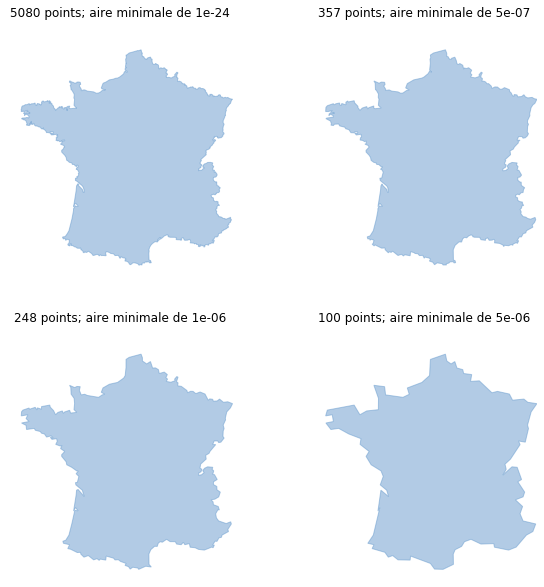

In [8]:
def addmap(x, y, max_area, ax):
    new_pol = visvalingam(x, y, max_area)
    nb_pts = len(new_pol.exterior.coords)

    # Tracing the polygon
    ax.add_patch(PolygonPatch(new_pol, fc='#6699cc', ec='#6699cc',
                              alpha=0.5, zorder=2))

    # Finitions
    ax.set_title("{} points; aire minimale de {}".format(nb_pts, max_area))
    ax.axis('scaled')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)

fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10, 10))

# First (bigger) polygon in France (Metropole)
a = MultiPolygon([france[0][0]])

for idx, p in enumerate(a):
    lon = np.array([lon for (lon, _) in list(p.exterior.coords)])
    lat = np.array([lat for (_, lat) in list(p.exterior.coords)])
    x, y = sph2lcc(np.radians(lon), np.radians(lat))
    
    addmap(x, y, 1e-24, ax[0][0])
    addmap(x, y, 5e-07, ax[0][1])
    addmap(x, y, 1e-06, ax[1][0])
    addmap(x, y, 5e-06, ax[1][1])


On peut alors choisir d'afficher notre carte précédente à une résolution inférieure sans perte apparente d'information.

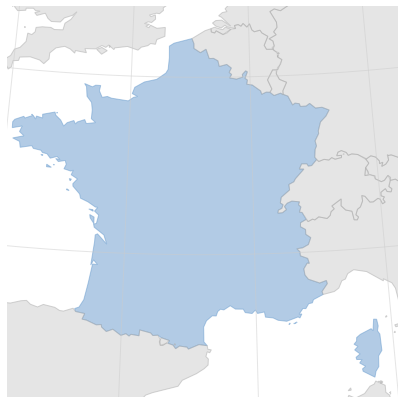

In [9]:
nice_plot(lambda x, y: visvalingam(x, y, 1e-6))

Si on choisit de simplifier la carte encore plus, on commence à voir des artefacts apparaître: les petits pays et les bords des frontières commencent à être déformés par l'algorithme, et une déformation pertinente d'un côté d'une frontière ne l'est plus forcément de l'autre.

Sur la carte ci-dessous, on voit des artefacts au niveau d'Andorre, du Luxembourg, du Liechtenstein, mais aussi au niveau de la frontière franco-germano-suisse. L'algorithme de Visvalingam et Whyatt peut encore être amélioré sur ces zones.

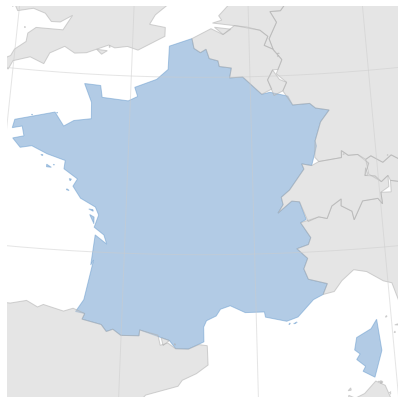

In [10]:
nice_plot(lambda x, y: visvalingam(x, y, 5e-6))